In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Polygon

In [2]:
dat_folder = 'data/'
files = ['3-pipelines-byte-policy.txt', '3-pipelines-latency-policy.txt']
n_pipelines = 3

header = ['latency', 'size']
column_names = ["Latency (ms)","Size (MB)"]
data = {}
dfs_dict = {}

zone_header = ['zone', 'latency']
zone_column_names = ["Zone", "Latency (ms)"]
zone_data = {}
dfs_zone_dict = {}


for file in files:
    data[file[:-4]] = [[] for _ in range(0,n_pipelines)]
    zone_data[file[:-4]] = [[] for _ in range(0,n_pipelines)]
    with open(dat_folder + file, "r") as to_read:
        for l in to_read.readlines():
            pipelines = l.split()
            for i in range(0,n_pipelines):
                x = pipelines[i].split("(")[1].split(",")
                zone = pipelines[i].split(":")[1][:-1]
                lat,byte = float(x[0]), float(x[1][:-1])
                data[file[:-4]][i] += [(lat,byte)]
                zone_data[file[:-4]][i] += [(zone,lat)]
        
for scenario in map(lambda s: s[:-4], files):
    dfs_pipelines = [pd.DataFrame(data[scenario][i], columns=column_names) for i in range(0, n_pipelines)]
    dfs_dict[scenario] = dfs_pipelines
    dfs_zone = [pd.DataFrame(zone_data[scenario][i], columns=zone_column_names) for i in range(0, n_pipelines)]
    dfs_zone_dict[scenario] = dfs_zone

# Mobility (Latency-based Policy)

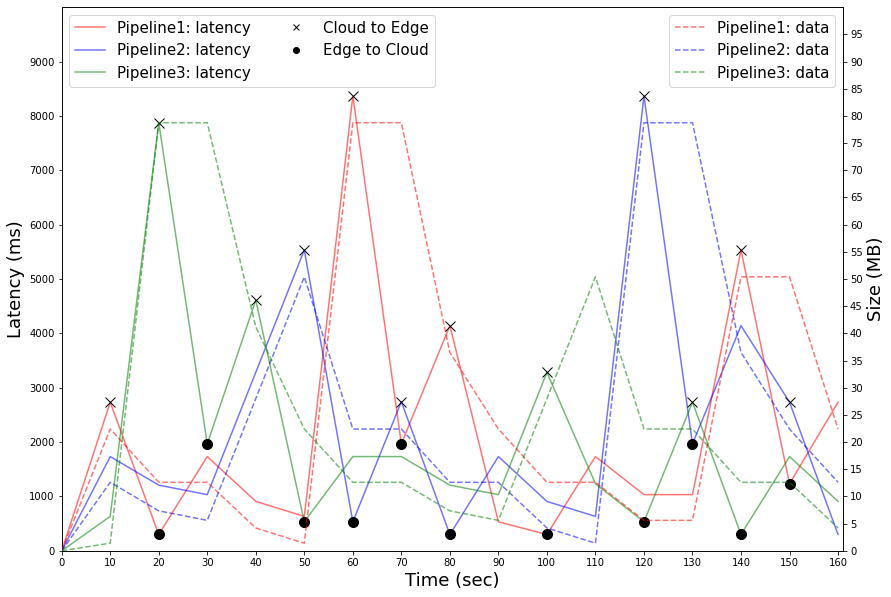

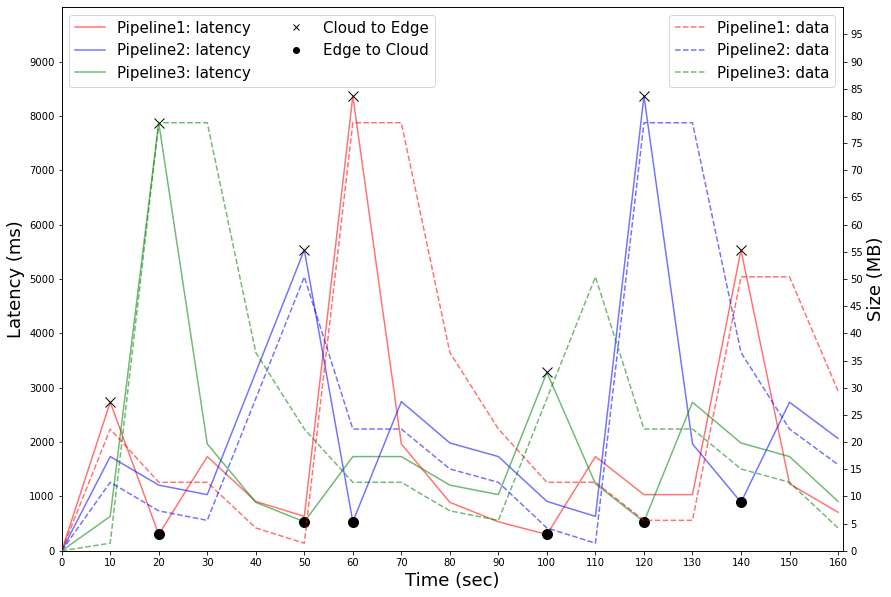

In [3]:
scenarios = ['3-pipelines-latency-policy', '3-pipelines-byte-policy']

x = [i*10 for i in range(0,len(dfs_dict[scenario][0]['Size (MB)']))]
swaps = {}

for scenario in scenarios:
    p1_byte = dfs_dict[scenario][0]['Size (MB)']
    p2_byte = dfs_dict[scenario][1]['Size (MB)']
    p3_byte = dfs_dict[scenario][2]['Size (MB)']
    p1_lat = dfs_dict[scenario][0]['Latency (ms)']
    p2_lat = dfs_dict[scenario][1]['Latency (ms)']
    p3_lat = dfs_dict[scenario][2]['Latency (ms)']
    
    swaps[scenario] = [0 for _ in range(0,n_pipelines)]

    fig = plt.figure(figsize=[14,10])
    ax = plt.subplot(111)
    ax_background = ax.twinx()
    ax.grid(False)
    ax_background.grid(False)

    # # define background plot for bytes
    b1 = ax_background.plot(
        x,
        p1_byte, 
        linestyle='dashed', 
        label='Pipeline1: data', 
        color='red', 
        zorder=100, 
        alpha=.55
    )

    b2 = ax_background.plot(
        x,
        p2_byte, 
        linestyle='dashed', 
        label='Pipeline2: data', 
        color='blue', 
        zorder=100, 
        alpha=.55
    )

    b3 = ax_background.plot(
        x,
        p3_byte, 
        linestyle='dashed', 
        label='Pipeline3: data', 
        color='green', 
        zorder=100, 
        alpha=.55
    )


    # #####latency#####

    l1 = ax.plot(
        x,
        p1_lat, 
        linestyle='solid', 
        label='Pipeline1: latency', 
        color='red', 
        zorder=1, 
        alpha=.55
    )

    l2 = ax.plot(
        x,
        p2_lat, 
        linestyle='solid', 
        label='Pipeline2: latency', 
        color='blue', 
        zorder=1, 
        alpha=.55
    )

    l3 = ax.plot(
        x,
        p3_lat, 
        linestyle='solid', 
        label='Pipeline3: latency', 
        color='green', 
        zorder=1, 
        alpha=.55
    )
    
    
    ###swap points#####

    # x (cloud -> edge) o (edge -> cloud)
    ms = 7
    pipeline_index = 0
    for pipeline in dfs_zone_dict[scenario]:
        last_zone = 'cloud'
        for i in range(0,len(pipeline)):
            curr_zone = pipeline['Zone'][i]
            if(curr_zone != last_zone):
                swaps[scenario][pipeline_index] +=  1
                lat = pipeline['Latency (ms)'][i-1]
                ax.plot(x[i-1], lat, linewidth=100000, marker= "x" if curr_zone == "edge" else "o", markersize=ms+3, markeredgecolor="black", markerfacecolor="black", zorder=10000)
                last_zone = curr_zone
        pipeline_index += 1
    ax.plot([],[],'x',label="Cloud to Edge", color='black')
    ax.plot([],[],'o',label="Edge to Cloud", color='black')

    
    
    
    # set ticks and labels
    ax.set_xlabel('Time (sec)', fontsize=18)


    # background ticks and labels
    ax.set_yticks(range(0, 10000, 1000))
    ax_background.set_yticks(range(0, 100, 5))
    ax.set_ylim(-.0001, 10000)
    ax_background.set_ylim(-.0001, 100)
    ax.set_ylabel('Latency (ms)', fontsize=18)
    ax_background.set_ylabel('Size (MB)', fontsize=18)
    ax.set_xlim(0, 161)
    ax.set_xticks(range(0, 161, 10))

    # legend settings
    ax.legend(loc='upper left', ncol=2, frameon=True, fontsize=15)
    
    ax_background.legend(loc='upper right', ncol=1, frameon=True, fontsize=15)
    
    fig.savefig(f'images/{scenario}.pdf', dpi=100)

In [6]:
for scenario in scenarios:
    print("###" + scenario + "###")
    mean_area = 0
    mean_lat = 0
    for i in range(0,len(dfs_dict[scenario])):
        area = np.trapz(dfs_dict[scenario][i]['Latency (ms)'], dx=5)
        avg_lat = sum(dfs_dict[scenario][i]['Latency (ms)'] / len(dfs_dict[scenario][i]['Latency (ms)']))
        mean_lat += avg_lat
        mean_area += area
        print("PIPELINE " + str(i) + " AUC = " + str(area) + ", AVG Latency = " + str(avg_lat) + ", SWAPS = " + str(swaps[scenario][i]))

    print("MEAN AUC: " + str(mean_area / len(dfs_dict[scenario])) + ", MEAN AVG = " + str(mean_lat / len(dfs_dict[scenario])))
    

###3-pipelines-latency-policy###
PIPELINE 0 AUC = 167750.0, AVG Latency = 2053.921568627451, SWAPS = 8
PIPELINE 1 AUC = 185013.88888888888, AVG Latency = 2185.4575163398695, SWAPS = 7
PIPELINE 2 AUC = 157993.05555555556, AVG Latency = 1885.4575163398695, SWAPS = 8
MEAN AUC: 170252.3148148148, MEAN AVG = 2041.61220043573
###3-pipelines-byte-policy###
PIPELINE 0 AUC = 146437.5, AVG Latency = 1743.6274509803925, SWAPS = 5
PIPELINE 1 AUC = 181597.22222222222, AVG Latency = 2197.222222222222, SWAPS = 4
PIPELINE 2 AUC = 147812.5, AVG Latency = 1765.6862745098042, SWAPS = 4
MEAN AUC: 158615.74074074076, MEAN AVG = 1902.1786492374729
